<a href="https://colab.research.google.com/github/arze04/PSMDSRC103_SY20252026A/blob/main/Enrollment_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

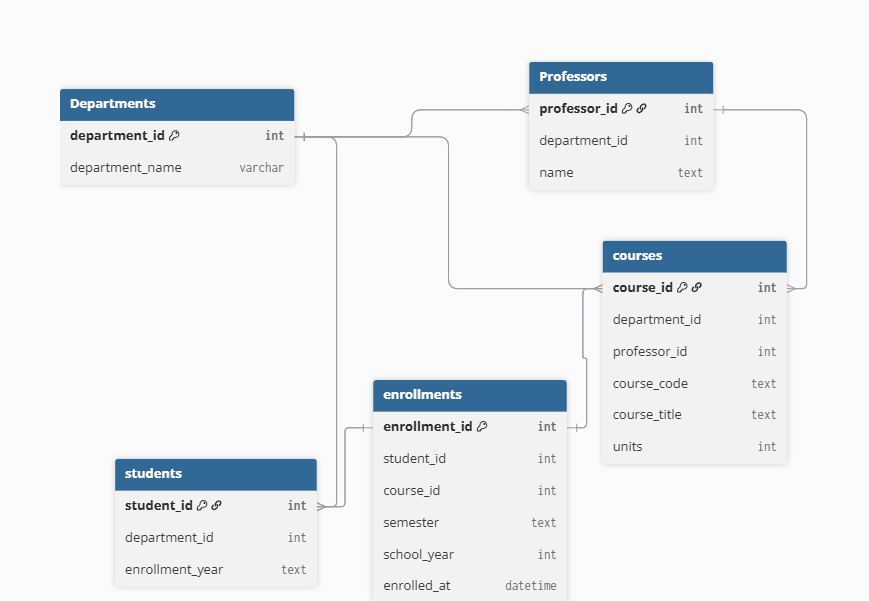

In [1]:
import sqlite3
import pandas as pd
from dataclasses import dataclass
from typing import Optional
import matplotlib.pyplot as plt

DB_NAME = "enrollment_notebook.db"
MAX_UNITS = 18
DEFAULT_UNITS = 3
DEFAULT_CAPACITY = 35


In [2]:
conn = sqlite3.connect(DB_NAME)
conn.row_factory = sqlite3.Row
conn.execute("PRAGMA foreign_keys = ON;")


In [3]:
def create_schema(conn):
    with conn:
        conn.executescript(
            """
            CREATE TABLE IF NOT EXISTS departments(
                department_id   INTEGER PRIMARY KEY AUTOINCREMENT,
                department_name TEXT UNIQUE NOT NULL
            );

            CREATE TABLE IF NOT EXISTS professors(
                professor_id  INTEGER PRIMARY KEY AUTOINCREMENT,
                department_id INTEGER NOT NULL,
                name          TEXT NOT NULL,
                FOREIGN KEY (department_id) REFERENCES departments(department_id)
                    ON UPDATE CASCADE ON DELETE RESTRICT
            );

            CREATE TABLE IF NOT EXISTS students(
                student_id      INTEGER PRIMARY KEY AUTOINCREMENT,
                student_code    TEXT UNIQUE NOT NULL,
                department_id   INTEGER NOT NULL,
                enrollment_year INTEGER NOT NULL,
                FOREIGN KEY (department_id) REFERENCES departments(department_id)
                    ON UPDATE CASCADE ON DELETE RESTRICT
            );

            CREATE TABLE IF NOT EXISTS courses(
                course_id     INTEGER PRIMARY KEY AUTOINCREMENT,
                department_id INTEGER NOT NULL,
                professor_id  INTEGER NOT NULL,
                course_code   TEXT UNIQUE NOT NULL,
                course_title  TEXT,
                units         INTEGER NOT NULL DEFAULT 3,
                capacity      INTEGER NOT NULL DEFAULT 35,
                FOREIGN KEY (department_id) REFERENCES departments(department_id)
                    ON UPDATE CASCADE ON DELETE RESTRICT,
                FOREIGN KEY (professor_id) REFERENCES professors(professor_id)
                    ON UPDATE CASCADE ON DELETE RESTRICT
            );

            CREATE TABLE IF NOT EXISTS enrollments(
                enrollment_id INTEGER PRIMARY KEY AUTOINCREMENT,
                student_id    INTEGER NOT NULL,
                course_id     INTEGER NOT NULL,
                semester      TEXT NOT NULL,
                school_year   INTEGER NOT NULL,
                enrolled_at   TEXT NOT NULL DEFAULT (datetime('now')),
                FOREIGN KEY (student_id) REFERENCES students(student_id)
                    ON UPDATE CASCADE ON DELETE CASCADE,
                FOREIGN KEY (course_id) REFERENCES courses(course_id)
                    ON UPDATE CASCADE ON DELETE CASCADE,
                UNIQUE(student_id, course_id, semester, school_year)
            );
            """
        )

create_schema(conn)


In [4]:
@dataclass
class Department:
    name: str
    department_id: Optional[int] = None

    def save(self, conn):
        with conn:
            if self.department_id is None:
                conn.execute("INSERT INTO departments(department_name) VALUES (?)",
                             (self.name,))
                cur = conn.execute("SELECT department_id FROM departments WHERE department_name=?",
                                   (self.name,))
                self.department_id = cur.fetchone()["department_id"]
            else:
                conn.execute("UPDATE departments SET department_name=? WHERE department_id=?",
                             (self.name, self.department_id))

    def delete(self, conn):
        with conn:
            conn.execute("DELETE FROM departments WHERE department_id=?",
                         (self.department_id,))


@dataclass
class Professor:
    name: str
    department_id: int
    professor_id: Optional[int] = None

    def save(self, conn):
        with conn:
            if self.professor_id is None:
                conn.execute("INSERT INTO professors(name, department_id) VALUES (?, ?)",
                             (self.name, self.department_id))
                cur = conn.execute(
                    "SELECT professor_id FROM professors WHERE name=? AND department_id=?",
                    (self.name, self.department_id))
                self.professor_id = cur.fetchone()["professor_id"]
            else:
                conn.execute(
                    "UPDATE professors SET name=?, department_id=? WHERE professor_id=?",
                    (self.name, self.department_id, self.professor_id))

    def delete(self, conn):
        with conn:
            conn.execute("DELETE FROM professors WHERE professor_id=?",
                         (self.professor_id,))


@dataclass
class Student:
    student_code: str
    department_id: int
    enrollment_year: int
    student_id: Optional[int] = None

    def save(self, conn):
        with conn:
            if self.student_id is None:
                conn.execute(
                    "INSERT INTO students(student_code, department_id, enrollment_year) "
                    "VALUES (?, ?, ?)",
                    (self.student_code, self.department_id, self.enrollment_year))
                cur = conn.execute(
                    "SELECT student_id FROM students WHERE student_code=?",
                    (self.student_code,))
                self.student_id = cur.fetchone()["student_id"]
            else:
                conn.execute(
                    "UPDATE students SET student_code=?, department_id=?, enrollment_year=? "
                    "WHERE student_id=?",
                    (self.student_code, self.department_id, self.enrollment_year, self.student_id))

    def delete(self, conn):
        with conn:
            conn.execute("DELETE FROM students WHERE student_id=?",
                         (self.student_id,))


@dataclass
class Course:
    course_code: str
    department_id: int
    professor_id: int
    course_title: str = ""
    units: int = DEFAULT_UNITS
    capacity: int = DEFAULT_CAPACITY
    course_id: Optional[int] = None

    def save(self, conn):
        with conn:
            if self.course_id is None:
                conn.execute(
                    "INSERT INTO courses(course_code, department_id, professor_id, "
                    "course_title, units, capacity) VALUES (?, ?, ?, ?, ?, ?)",
                    (self.course_code, self.department_id, self.professor_id,
                     self.course_title, self.units, self.capacity))
                cur = conn.execute(
                    "SELECT course_id FROM courses WHERE course_code=?",
                    (self.course_code,))
                self.course_id = cur.fetchone()["course_id"]
            else:
                conn.execute(
                    "UPDATE courses SET course_code=?, department_id=?, professor_id=?, "
                    "course_title=?, units=?, capacity=? WHERE course_id=?",
                    (self.course_code, self.department_id, self.professor_id,
                     self.course_title, self.units, self.capacity, self.course_id))


In [5]:
class EnrollmentSystem:
    def __init__(self, conn):
        self.conn = conn
        self.conn.execute("PRAGMA foreign_keys = ON;")

    # ---------- Get or create ----------
    def get_or_create_department(self, name):
        row = self.conn.execute(
            "SELECT department_id FROM departments WHERE department_name=?",
            (name,)
        ).fetchone()
        if row:
            return row["department_id"]
        dept = Department(name)
        dept.save(self.conn)
        return dept.department_id

    def get_or_create_professor(self, name, department_id):
        row = self.conn.execute(
            "SELECT professor_id FROM professors WHERE name=? AND department_id=?",
            (name, department_id)
        ).fetchone()
        if row:
            return row["professor_id"]
        prof = Professor(name, department_id)
        prof.save(self.conn)
        return prof.professor_id

    def get_or_create_student(self, code, dept_id, year):
        row = self.conn.execute(
            "SELECT student_id FROM students WHERE student_code=?",
            (code,)
        ).fetchone()
        if row:
            return row["student_id"]
        student = Student(code, dept_id, year)
        student.save(self.conn)
        return student.student_id

    def get_or_create_course(self, code, dept_id, prof_id,
                             title="", units=DEFAULT_UNITS, capacity=DEFAULT_CAPACITY):
        row = self.conn.execute(
            "SELECT course_id FROM courses WHERE course_code=?",
            (code,)
        ).fetchone()
        if row:
            return row["course_id"]
        course = Course(code, dept_id, prof_id, title, units, capacity)
        course.save(self.conn)
        return course.course_id

    # ---------- List methods ----------
    def list_students(self):
        return pd.read_sql_query(
            """
            SELECT s.student_id, s.student_code, d.department_name, s.enrollment_year
            FROM students s
            JOIN departments d ON d.department_id=s.department_id
            ORDER BY s.student_code
            """, self.conn)

    def list_professors(self):
        return pd.read_sql_query(
            """
            SELECT p.professor_id, p.name, d.department_name
            FROM professors p
            JOIN departments d ON d.department_id=p.department_id
            ORDER BY p.name
            """, self.conn)

    def list_departments(self):
        return pd.read_sql_query(
            "SELECT * FROM departments ORDER BY department_name",
            self.conn)

    def list_courses(self):
        return pd.read_sql_query(
            """
            SELECT c.course_id, c.course_code, c.course_title,
                   d.department_name, p.name AS professor_name,
                   c.units, c.capacity
            FROM courses c
            JOIN departments d ON d.department_id=c.department_id
            JOIN professors p ON p.professor_id=c.professor_id
            ORDER BY c.course_code
            """, self.conn)

    def list_enrollments(self):
        return pd.read_sql_query(
            """
            SELECT e.enrollment_id, s.student_code, c.course_code,
                   e.semester, e.school_year, e.enrolled_at
            FROM enrollments e
            JOIN students s ON s.student_id=e.student_id
            JOIN courses c ON c.course_id=e.course_id
            ORDER BY e.school_year DESC, e.semester, s.student_code
            """, self.conn)

    # ---------- Enrollment logic ----------
    def enroll_student_in_course(self, student_code, course_code,
                                 semester, school_year, enforce_rules=True):

        student_row = self.conn.execute(
            "SELECT student_id FROM students WHERE student_code=?",
            (student_code,)
        ).fetchone()

        course_row = self.conn.execute(
            "SELECT * FROM courses WHERE course_code=?",
            (course_code,)
        ).fetchone()

        if not student_row or not course_row:
            print("Unknown student or course.")
            return False

        student_id = student_row["student_id"]
        course_id = course_row["course_id"]

        exists = self.conn.execute(
            """
            SELECT 1 FROM enrollments
            WHERE student_id=? AND course_id=? AND semester=? AND school_year=?
            """, (student_id, course_id, semester, school_year)
        ).fetchone()

        if exists:
            print("Duplicate enrollment blocked.")
            return False

        if enforce_rules:
            total_units = self.conn.execute(
                """
                SELECT COALESCE(SUM(c.units), 0) AS total
                FROM enrollments e
                JOIN courses c ON c.course_id=e.course_id
                WHERE e.student_id=? AND e.semester=? AND e.school_year=?
                """, (student_id, semester, school_year)
            ).fetchone()["total"]

            if total_units + course_row["units"] > MAX_UNITS:
                print("Maximum unit load exceeded.")
                return False

            enrolled_count = self.conn.execute(
                """
                SELECT COUNT(*) AS cnt
                FROM enrollments
                WHERE course_id=? AND semester=? AND school_year=?
                """, (course_id, semester, school_year)
            ).fetchone()["cnt"]

            if enrolled_count >= course_row["capacity"]:
                print("Course is at capacity.")
                return False

        with self.conn:
            self.conn.execute(
                "INSERT INTO enrollments(student_id, course_id, semester, school_year) "
                "VALUES (?, ?, ?, ?)",
                (student_id, course_id, semester, school_year)
            )

        return True

    # ---------- CSV loader ----------
    def load_from_csv(self, csv_path, semester="1st", school_year=2025, enrollment_year=2025):
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            dept = self.get_or_create_department(row["department"])
            prof = self.get_or_create_professor(row["professor"], dept)
            self.get_or_create_student(row["student"], dept, enrollment_year)
            self.get_or_create_course(
                row["course"], dept, prof,
                title=row["course"], units=DEFAULT_UNITS, capacity=DEFAULT_CAPACITY
            )

            self.enroll_student_in_course(
                row["student"], row["course"],
                semester, school_year, enforce_rules=False
            )

    # ---------- Reports ----------
    def course_roster(self, course_code):
        return pd.read_sql_query(
            """
            SELECT s.student_code, c.course_code, p.name AS professor_name
            FROM enrollments e
            JOIN students s ON s.student_id=e.student_id
            JOIN courses c ON c.course_id=e.course_id
            JOIN professors p ON p.professor_id=c.professor_id
            WHERE c.course_code=?
            ORDER BY s.student_code
            """, self.conn, params=(course_code,))

    def student_timetable(self, student_code):
        return pd.read_sql_query(
            """
            SELECT s.student_code, c.course_code, c.course_title,
                   d.department_name, e.semester, e.school_year
            FROM enrollments e
            JOIN students s ON s.student_id=e.student_id
            JOIN courses c ON c.course_id=e.course_id
            JOIN departments d ON d.department_id=c.department_id
            WHERE s.student_code=?
            ORDER BY e.school_year, e.semester
            """, self.conn, params=(student_code,))

    def department_summary(self):
        return pd.read_sql_query(
            """
            WITH section_sizes AS (
                SELECT c.course_id, COUNT(e.student_id) AS size
                FROM courses c
                LEFT JOIN enrollments e ON c.course_id=e.course_id
                GROUP BY c.course_id
            )
            SELECT d.department_name,
                   COUNT(DISTINCT c.course_id) AS num_courses,
                   COUNT(DISTINCT e.student_id) AS num_students,
                   ROUND(AVG(size), 2) AS avg_section_size
            FROM departments d
            LEFT JOIN courses c ON c.department_id=d.department_id
            LEFT JOIN enrollments e ON c.course_id=e.course_id
            LEFT JOIN section_sizes s ON s.course_id=c.course_id
            GROUP BY d.department_id
            ORDER BY d.department_name
            """, self.conn)


In [6]:
system = EnrollmentSystem(conn)

data = r"/content/enrollment_data_2025.csv"

system.load_from_csv(data)

In [7]:
print("Students:")
display(system.list_students().head())
print("Courses:")
display(system.list_courses().head())
print("Professors:")
display(system.list_professors().head())
print("Enrollments:")
display(system.list_enrollments().head())


Students:


,student_id,student_code,department_name,enrollment_year
0,1,Student001,Mathematics,2025
1,2,Student002,Mathematics,2025
2,3,Student003,Chemistry,2025
3,4,Student004,Mathematics,2025
4,5,Student005,Chemistry,2025


Courses:


,course_id,course_code,course_title,department_name,professor_name,units,capacity
0,11,BIO101,BIO101,Biology,Dr. Eva Brown,3,35
1,12,BIO201,BIO201,Biology,Dr. Jason Turner,3,35
2,3,CHEM101,CHEM101,Chemistry,Dr. Irene Thomas,3,35
3,5,CHEM201,CHEM201,Chemistry,Dr. David Kim,3,35
4,10,CS101,CS101,Computer Science,Dr. Alice Johnson,3,35


Professors:


,professor_id,name,department_name
0,6,Dr. Alice Johnson,Computer Science
1,4,Dr. Bob Smith,Mathematics
2,8,Dr. Carol Lee,Physics
3,3,Dr. David Kim,Chemistry
4,9,Dr. Eva Brown,Biology


Enrollments:


,enrollment_id,student_code,course_code,semester,school_year,enrolled_at
0,1,Student001,MATH201,1st,2025,2025-11-22 14:10:12
1,2,Student002,MATH301,1st,2025,2025-11-22 14:10:12
2,3,Student003,CHEM101,1st,2025,2025-11-22 14:10:12
3,4,Student004,MATH101,1st,2025,2025-11-22 14:10:12
4,5,Student005,CHEM201,1st,2025,2025-11-22 14:10:12


In [8]:
import sqlite3

# -------- Department CRUD --------
def create_department(conn):
    print("\n=== CREATE DEPARTMENT ===")
    name = input("Department name: ").strip()
    if not name:
        print("Name cannot be empty.")
        return
    try:
        with conn:
            conn.execute(
                "INSERT INTO departments(department_name) VALUES (?)",
                (name,)
            )
        print("Department created.")
    except sqlite3.IntegrityError:
        print("Department already exists.")


def read_department(conn):
    print("\n=== READ DEPARTMENT ===")
    name = input("Department name: ").strip()
    row = conn.execute(
        "SELECT department_id, department_name FROM departments WHERE department_name=?",
        (name,)
    ).fetchone()
    if row:
        print(f"ID   : {row['department_id']}")
        print(f"Name : {row['department_name']}")
    else:
        print("Department not found.")


def update_department(conn):
    print("\n=== UPDATE DEPARTMENT ===")
    old_name = input("Current department name: ").strip()
    row = conn.execute(
        "SELECT department_id, department_name FROM departments WHERE department_name=?",
        (old_name,)
    ).fetchone()
    if not row:
        print("Department not found.")
        return

    new_name = input(f"New name (leave blank to keep '{row['department_name']}'): ").strip()
    if not new_name:
        new_name = row["department_name"]

    try:
        with conn:
            conn.execute(
                "UPDATE departments SET department_name=? WHERE department_id=?",
                (new_name, row["department_id"])
            )
        print("Department updated.")
    except sqlite3.IntegrityError:
        print("Another department with that name already exists.")


def delete_department(conn):
    print("\n=== DELETE DEPARTMENT ===")
    name = input("Department name to delete: ").strip()
    row = conn.execute(
        "SELECT department_id FROM departments WHERE department_name=?",
        (name,)
    ).fetchone()
    if not row:
        print("Department not found.")
        return

    confirm = input(f"Are you sure you want to delete '{name}'? (y/N): ").strip().lower()
    if confirm == "y":
        with conn:
            conn.execute("DELETE FROM departments WHERE department_id=?", (row["department_id"],))
        print("Department deleted.")
    else:
        print("Cancelled.")


def department_menu(system, conn):
    while True:
        print("\n=== DEPARTMENT MENU ===")
        print("1. Create department")
        print("2. Read department")
        print("3. Update department")
        print("4. Delete department")
        print("5. List departments")
        print("0. Back")
        choice = input("Choice: ").strip()

        if choice == "1":
            create_department(conn)
        elif choice == "2":
            read_department(conn)
        elif choice == "3":
            update_department(conn)
        elif choice == "4":
            delete_department(conn)
        elif choice == "5":
            display(system.list_departments())
        elif choice == "0":
            break
        else:
            print("Invalid choice.")


# -------- Professor CRUD --------
def create_professor(system, conn):
    print("\n=== CREATE PROFESSOR ===")
    name = input("Professor name: ").strip()
    dept_name = input("Department name: ").strip()
    if not name or not dept_name:
        print("Name and department are required.")
        return
    dept_id = system.get_or_create_department(dept_name)
    with conn:
        conn.execute(
            "INSERT INTO professors(name, department_id) VALUES (?, ?)",
            (name, dept_id)
        )
    print("Professor created.")


def read_professor(conn):
    print("\n=== READ PROFESSOR ===")
    name = input("Professor name: ").strip()
    row = conn.execute(
        """
        SELECT p.professor_id, p.name, d.department_name
        FROM professors p
        JOIN departments d ON d.department_id=p.department_id
        WHERE p.name=?
        """,
        (name,)
    ).fetchone()
    if row:
        print(f"ID         : {row['professor_id']}")
        print(f"Name       : {row['name']}")
        print(f"Department : {row['department_name']}")
    else:
        print("Professor not found.")


def update_professor(system, conn):
    print("\n=== UPDATE PROFESSOR ===")
    name = input("Current professor name: ").strip()
    row = conn.execute(
        "SELECT professor_id, name, department_id FROM professors WHERE name=?",
        (name,)
    ).fetchone()
    if not row:
        print("Professor not found.")
        return

    new_name = input(f"New name (leave blank to keep '{row['name']}'): ").strip()
    new_dept = input("New department (leave blank to keep current): ").strip()

    if not new_name:
        new_name = row["name"]

    if not new_dept:
        new_dept_id = row["department_id"]
    else:
        new_dept_id = system.get_or_create_department(new_dept)

    with conn:
        conn.execute(
            "UPDATE professors SET name=?, department_id=? WHERE professor_id=?",
            (new_name, new_dept_id, row["professor_id"])
        )
    print("Professor updated.")


def delete_professor(conn):
    print("\n=== DELETE PROFESSOR ===")
    name = input("Professor name to delete: ").strip()
    row = conn.execute(
        "SELECT professor_id FROM professors WHERE name=?",
        (name,)
    ).fetchone()
    if not row:
        print("Professor not found.")
        return

    confirm = input(f"Are you sure you want to delete '{name}'? (y/N): ").strip().lower()
    if confirm == "y":
        with conn:
            conn.execute("DELETE FROM professors WHERE professor_id=?", (row["professor_id"],))
        print("Professor deleted.")
    else:
        print("Cancelled.")


def professor_menu(system, conn):
    while True:
        print("\n=== PROFESSOR MENU ===")
        print("1. Create professor")
        print("2. Read professor")
        print("3. Update professor")
        print("4. Delete professor")
        print("5. List professors")
        print("0. Back")
        choice = input("Choice: ").strip()

        if choice == "1":
            create_professor(system, conn)
        elif choice == "2":
            read_professor(conn)
        elif choice == "3":
            update_professor(system, conn)
        elif choice == "4":
            delete_professor(conn)
        elif choice == "5":
            display(system.list_professors())
        elif choice == "0":
            break
        else:
            print("Invalid choice.")


# -------- Student CRUD --------
def create_student_account(system, conn):
    print("\n=== CREATE STUDENT ===")
    student_code = input("Student code: ").strip()
    dept_name = input("Department name: ").strip()
    year = input("Enrollment year: ").strip()

    if not student_code or not dept_name or not year:
        print("All fields are required.")
        return

    try:
        year_val = int(year)
    except ValueError:
        print("Invalid year.")
        return

    dept_id = system.get_or_create_department(dept_name)

    try:
        with conn:
            conn.execute(
                "INSERT INTO students(student_code, department_id, enrollment_year) "
                "VALUES (?, ?, ?)",
                (student_code, dept_id, year_val)
            )
        print("Student created.")
    except sqlite3.IntegrityError:
        print("Student code already exists.")


def read_student_account(conn):
    print("\n=== READ STUDENT ===")
    code = input("Student code: ").strip()
    row = conn.execute(
        """
        SELECT s.student_id, s.student_code, s.enrollment_year,
               d.department_name
        FROM students s
        JOIN departments d ON d.department_id=s.department_id
        WHERE s.student_code=?
        """, (code,)
    ).fetchone()
    if row:
        print(f"ID         : {row['student_id']}")
        print(f"Code       : {row['student_code']}")
        print(f"Department : {row['department_name']}")
        print(f"Year       : {row['enrollment_year']}")
    else:
        print("Student not found.")


def update_student_account(system, conn):
    print("\n=== UPDATE STUDENT ===")
    code = input("Current student code: ").strip()
    row = conn.execute(
        "SELECT * FROM students WHERE student_code=?",
        (code,)
    ).fetchone()
    if not row:
        print("Student not found.")
        return

    new_code = input(f"New code (blank to keep '{row['student_code']}'): ").strip()
    new_dept = input("New department (blank to keep current): ").strip()
    new_year = input(f"New year (blank to keep '{row['enrollment_year']}'): ").strip()

    if not new_code:
        new_code = row["student_code"]

    if not new_dept:
        new_dept_id = row["department_id"]
    else:
        new_dept_id = system.get_or_create_department(new_dept)

    if not new_year:
        new_year_val = row["enrollment_year"]
    else:
        try:
            new_year_val = int(new_year)
        except ValueError:
            print("Invalid year.")
            return

    try:
        with conn:
            conn.execute(
                "UPDATE students SET student_code=?, department_id=?, enrollment_year=? "
                "WHERE student_id=?",
                (new_code, new_dept_id, new_year_val, row["student_id"])
            )
        print("Student updated.")
    except sqlite3.IntegrityError:
        print("Student code already exists.")


def delete_student_account(conn):
    print("\n=== DELETE STUDENT ===")
    code = input("Student code to delete: ").strip()
    row = conn.execute(
        "SELECT student_id FROM students WHERE student_code=?",
        (code,)
    ).fetchone()
    if not row:
        print("Student not found.")
        return

    confirm = input(f"Are you sure you want to delete '{code}'? (y/N): ").strip().lower()
    if confirm == "y":
        with conn:
            conn.execute("DELETE FROM students WHERE student_id=?", (row["student_id"],))
        print("Student deleted.")
    else:
        print("Cancelled.")


def student_menu(system, conn):
    while True:
        print("\n=== STUDENT MENU ===")
        print("1. Create student")
        print("2. Read student")
        print("3. Update student")
        print("4. Delete student")
        print("5. List students")
        print("0. Back")
        choice = input("Choice: ").strip()

        if choice == "1":
            create_student_account(system, conn)
        elif choice == "2":
            read_student_account(conn)
        elif choice == "3":
            update_student_account(system, conn)
        elif choice == "4":
            delete_student_account(conn)
        elif choice == "5":
            display(system.list_students().head(50))
        elif choice == "0":
            break
        else:
            print("Invalid choice.")


# -------- Course CRUD --------
def create_course(system, conn):
    print("\n=== CREATE COURSE ===")
    code = input("Course code: ").strip()
    title = input("Course title: ").strip()
    dept_name = input("Department name: ").strip()
    prof_name = input("Professor name: ").strip()
    units = input("Units (default 3): ").strip()
    capacity = input("Capacity (default 35): ").strip()

    if not code or not dept_name or not prof_name:
        print("Course code, department and professor are required.")
        return

    dept_id = system.get_or_create_department(dept_name)
    prof_id = system.get_or_create_professor(prof_name, dept_id)

    if not units:
        units_val = DEFAULT_UNITS
    else:
        units_val = int(units)

    if not capacity:
        cap_val = DEFAULT_CAPACITY
    else:
        cap_val = int(capacity)

    with conn:
        conn.execute(
            """
            INSERT INTO courses(course_code, department_id, professor_id,
                                course_title, units, capacity)
            VALUES (?, ?, ?, ?, ?, ?)
            """,
            (code, dept_id, prof_id, title, units_val, cap_val)
        )
    print("Course created.")


def read_course(conn):
    print("\n=== READ COURSE ===")
    code = input("Course code: ").strip()
    row = conn.execute(
        """
        SELECT c.course_id, c.course_code, c.course_title,
               d.department_name, p.name AS professor_name,
               c.units, c.capacity
        FROM courses c
        JOIN departments d ON d.department_id=c.department_id
        JOIN professors p ON p.professor_id=c.professor_id
        WHERE c.course_code=?
        """,
        (code,)
    ).fetchone()

    if row:
        print(f"ID         : {row['course_id']}")
        print(f"Code       : {row['course_code']}")
        print(f"Title      : {row['course_title']}")
        print(f"Department : {row['department_name']}")
        print(f"Professor  : {row['professor_name']}")
        print(f"Units      : {row['units']}")
        print(f"Capacity   : {row['capacity']}")
    else:
        print("Course not found.")


def update_course(system, conn):
    print("\n=== UPDATE COURSE ===")
    code = input("Current course code: ").strip()
    row = conn.execute(
        "SELECT * FROM courses WHERE course_code=?",
        (code,)
    ).fetchone()
    if not row:
        print("Course not found.")
        return

    new_code = input(f"New code (blank to keep '{row['course_code']}'): ").strip()
    new_title = input(f"New title (blank to keep '{row['course_title']}'): ").strip()
    new_dept = input("New department (blank to keep current): ").strip()
    new_prof = input("New professor (blank to keep current): ").strip()
    new_units = input(f"New units (blank to keep '{row['units']}'): ").strip()
    new_cap = input(f"New capacity (blank to keep '{row['capacity']}'): ").strip()

    if not new_code:
        new_code = row["course_code"]
    if not new_title:
        new_title = row["course_title"]

    if not new_dept:
        dept_id = row["department_id"]
    else:
        dept_id = system.get_or_create_department(new_dept)

    if not new_prof:
        prof_id = row["professor_id"]
    else:
        prof_id = system.get_or_create_professor(new_prof, dept_id)

    if not new_units:
        units_val = row["units"]
    else:
        units_val = int(new_units)

    if not new_cap:
        cap_val = row["capacity"]
    else:
        cap_val = int(new_cap)

    with conn:
        conn.execute(
            """
            UPDATE courses
            SET course_code=?, department_id=?, professor_id=?,
                course_title=?, units=?, capacity=?
            WHERE course_id=?
            """,
            (new_code, dept_id, prof_id, new_title, units_val, cap_val, row["course_id"])
        )
    print("Course updated.")


def delete_course(conn):
    print("\n=== DELETE COURSE ===")
    code = input("Course code to delete: ").strip()
    row = conn.execute(
        "SELECT course_id FROM courses WHERE course_code=?",
        (code,)
    ).fetchone()
    if not row:
        print("Course not found.")
        return

    confirm = input(f"Are you sure you want to delete '{code}'? (y/N): ").strip().lower()
    if confirm == "y":
        with conn:
            conn.execute("DELETE FROM courses WHERE course_id=?", (row["course_id"],))
        print("Course deleted.")
    else:
        print("Cancelled.")


def course_menu(system, conn):
    while True:
        print("\n=== COURSE MENU ===")
        print("1. Create course")
        print("2. Read course")
        print("3. Update course")
        print("4. Delete course")
        print("5. List courses")
        print("0. Back")
        choice = input("Choice: ").strip()

        if choice == "1":
            create_course(system, conn)
        elif choice == "2":
            read_course(conn)
        elif choice == "3":
            update_course(system, conn)
        elif choice == "4":
            delete_course(conn)
        elif choice == "5":
            display(system.list_courses().head(50))
        elif choice == "0":
            break
        else:
            print("Invalid choice.")


# -------- Main Menu --------
def main_menu(system, conn):
    while True:
        print("\n========== MAIN MENU ==========")
        print("1. Departments")
        print("2. Professors")
        print("3. Students")
        print("4. Courses")
        print("5. View enrollments")
        print("0. Exit")
        choice = input("Choice: ").strip()

        if choice == "1":
            department_menu(system, conn)
        elif choice == "2":
            professor_menu(system, conn)
        elif choice == "3":
            student_menu(system, conn)
        elif choice == "4":
            course_menu(system, conn)
        elif choice == "5":
            display(system.list_enrollments().head(50))
        elif choice == "0":
            print("Exiting system.")
            break
        else:
            print("Invalid choice.")


Department summary:


,department_name,num_courses,num_students,avg_section_size
0,Biology,2,25,12.52
1,Chemistry,2,23,12.04
2,Computer Science,3,36,13.56
3,Mathematics,3,44,15.09
4,Physics,2,22,11.36



Department with most students: Mathematics (44 students)


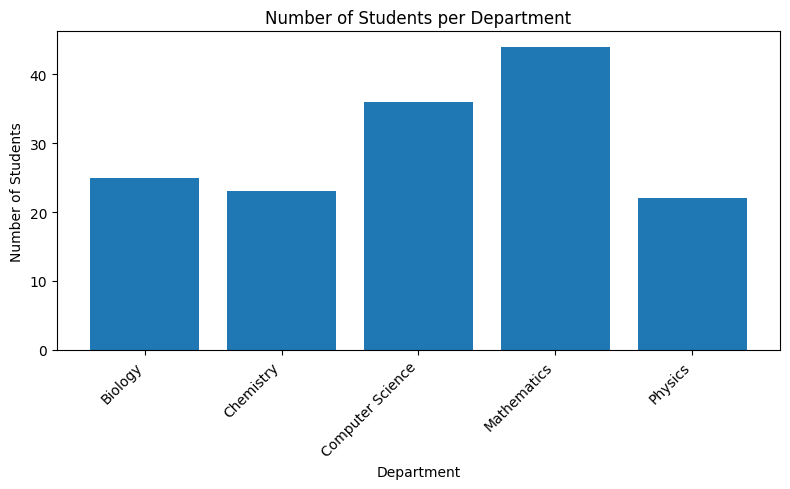

In [9]:
# Department summary analysis and bar plot
dept_summary = system.department_summary()
print("Department summary:")
display(dept_summary)

if not dept_summary.empty:
    top_dept = dept_summary.loc[dept_summary["num_students"].idxmax()]
    print(f"\nDepartment with most students: {top_dept['department_name']} "
          f"({top_dept['num_students']} students)")

    plt.figure(figsize=(8, 5))
    plt.bar(dept_summary["department_name"], dept_summary["num_students"])
    plt.title("Number of Students per Department")
    plt.xlabel("Department")
    plt.ylabel("Number of Students")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No data in department summary.")


In [ ]:
main_menu(system, conn)


========== MAIN MENU ==========
1. Departments
2. Professors
3. Students
4. Courses
5. View enrollments
0. Exit
Choice: 3

=== STUDENT MENU ===
1. Create student
2. Read student
3. Update student
4. Delete student
5. List students
0. Back
Choice: 1

=== CREATE STUDENT ===
Student code: Student51
Department name: Computer Science
Enrollment year: 2025
Student code already exists.

=== STUDENT MENU ===
1. Create student
2. Read student
3. Update student
4. Delete student
5. List students
0. Back
Choice: 1

=== CREATE STUDENT ===
Student code: Student52
Department name: Computer Science
Enrollment year: 2025
Student created.

=== STUDENT MENU ===
1. Create student
2. Read student
3. Update student
4. Delete student
5. List students
0. Back
Choice: 0

========== MAIN MENU ==========
1. Departments
2. Professors
3. Students
4. Courses
5. View enrollments
0. Exit
Choice: 4

=== COURSE MENU ===
1. Create course
2. Read course
3. Update course
4. Delete course
5. List courses
0. Back
Choice: 

,course_id,course_code,course_title,department_name,professor_name,units,capacity
0,11,BIO101,BIO101,Biology,Dr. Eva Brown,3,35
1,12,BIO201,BIO201,Biology,Dr. Jason Turner,3,35
2,3,CHEM101,CHEM101,Chemistry,Dr. Irene Thomas,3,35
3,5,CHEM201,CHEM201,Chemistry,Dr. David Kim,3,35
4,10,CS101,CS101,Computer Science,Dr. Alice Johnson,3,35
5,9,CS201,CS201,Computer Science,Dr. Frank White,3,35
6,8,CS301,CS301,Computer Science,Dr. Alice Johnson,3,35
7,4,MATH101,MATH101,Mathematics,Dr. Grace Black,3,35
8,1,MATH201,MATH201,Mathematics,Dr. Grace Black,3,35
9,2,MATH301,MATH301,Mathematics,Dr. Grace Black,3,35



=== COURSE MENU ===
1. Create course
2. Read course
3. Update course
4. Delete course
5. List courses
0. Back
Choice: 1

=== CREATE COURSE ===
Course code: CS104
Course title: Introduction to Programming
Department name: Computer Science
Professor name: Dr. Frank White
Units (default 3): 3
Capacity (default 35): 35
Course created.

=== COURSE MENU ===
1. Create course
2. Read course
3. Update course
4. Delete course
5. List courses
0. Back
Choice: 0

========== MAIN MENU ==========
1. Departments
2. Professors
3. Students
4. Courses
5. View enrollments
0. Exit
Choice: 5


,enrollment_id,student_code,course_code,semester,school_year,enrolled_at
0,1,Student001,MATH201,1st,2025,2025-11-22 14:10:12
1,2,Student002,MATH301,1st,2025,2025-11-22 14:10:12
2,3,Student003,CHEM101,1st,2025,2025-11-22 14:10:12
3,4,Student004,MATH101,1st,2025,2025-11-22 14:10:12
4,5,Student005,CHEM201,1st,2025,2025-11-22 14:10:12
5,6,Student006,MATH101,1st,2025,2025-11-22 14:10:12
6,7,Student007,PHY201,1st,2025,2025-11-22 14:10:12
7,8,Student008,PHY101,1st,2025,2025-11-22 14:10:12
8,9,Student009,MATH101,1st,2025,2025-11-22 14:10:12
9,10,Student010,CHEM201,1st,2025,2025-11-22 14:10:12



========== MAIN MENU ==========
1. Departments
2. Professors
3. Students
4. Courses
5. View enrollments
0. Exit
